In [0]:
! pip install -q kaggle

In [22]:
! ls

celeba-dataset.zip  list_attr_celeba.csv     list_landmarks_align_celeba.csv
img_align_celeba    list_bbox_celeba.csv     models
kaggle.json	    list_eval_partition.csv  sample_data


In [0]:
from google.colab import files
files.upload()

In [0]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [0]:
! kaggle datasets list

ref                                                          title                                                size  lastUpdated          downloadCount  
-----------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  
allen-institute-for-ai/CORD-19-research-challenge            COVID-19 Open Research Dataset Challenge (CORD-19)    3GB  2020-05-27 21:50:10          71785  
roche-data-science-coalition/uncover                         UNCOVER COVID-19 Challenge                          179MB  2020-05-21 18:57:53          10483  
ruchi798/tv-shows-on-netflix-prime-video-hulu-and-disney     TV shows on Netflix, Prime Video, Hulu and Disney+   88KB  2020-05-25 15:38:39             12  
ruchi798/movies-on-netflix-prime-video-hulu-and-disney       Movies on Netflix, Prime Video, Hulu and Disney+    627KB  2020-05-22 23:48:01             47  
ruchi798/malnutrition-across-the-globe                    

In [5]:
! kaggle datasets download -d jessicali9530/celeba-dataset

100% 1.33G/1.33G [00:12<00:00, 101MB/s] 
100% 1.33G/1.33G [00:12<00:00, 112MB/s]


In [6]:
! unzip -o celeba-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: img_align_celeba/img_align_celeba/197605.jpg  
  inflating: img_align_celeba/img_align_celeba/197606.jpg  
  inflating: img_align_celeba/img_align_celeba/197607.jpg  
  inflating: img_align_celeba/img_align_celeba/197608.jpg  
  inflating: img_align_celeba/img_align_celeba/197609.jpg  
  inflating: img_align_celeba/img_align_celeba/197610.jpg  
  inflating: img_align_celeba/img_align_celeba/197611.jpg  
  inflating: img_align_celeba/img_align_celeba/197612.jpg  
  inflating: img_align_celeba/img_align_celeba/197613.jpg  
  inflating: img_align_celeba/img_align_celeba/197614.jpg  
  inflating: img_align_celeba/img_align_celeba/197615.jpg  
  inflating: img_align_celeba/img_align_celeba/197616.jpg  
  inflating: img_align_celeba/img_align_celeba/197617.jpg  
  inflating: img_align_celeba/img_align_celeba/197618.jpg  
  inflating: img_align_celeba/img_align_celeba/197619.jpg  
  inflating: img_align_celeba/img_align_celeba/19

In [7]:
! mkdir models
! ls

celeba-dataset.zip  list_attr_celeba.csv     list_landmarks_align_celeba.csv
img_align_celeba    list_bbox_celeba.csv     models
kaggle.json	    list_eval_partition.csv  sample_data


In [0]:
import os
import cv2
import torch
from torch.utils.data import Dataset

class LoadCelebFaces(Dataset):
    def __init__(self, transform=None):
        self.PATH = "./img_align_celeba/img_align_celeba/"
        self.names = os.listdir(self.PATH)
        self.samples = [()] * len(self.names)
        self.transform = transform

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[idx]
        img = cv2.imread(self.PATH+name, cv2.IMREAD_GRAYSCALE)
        img = img / 255.0
        img = cv2.resize(img, (50, 50))
        if self.transform:
            img = self.transform(img)
        self.samples[idx] = img

        return self.samples[idx]

In [0]:
import torch.nn as nn
import torch.nn.functional as F
import torch

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # mx1x50x50
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 16, 4, 2, 0),
                nn.ReLU(),
                # mx16x24x24
                nn.Conv2d(16, 4, 4, 2, 0)
                # mx4x11x11
            )

        self.mean = nn.Linear(4*11*11, 800)
        self.std = nn.Linear(4*11*11, 800)

        self.convertor = nn.Linear(800, 4*11*11)

        self.decoder = nn.Sequential(
                # mx4x11x11
                nn.ConvTranspose2d(4, 16, 4, 2, 0),
                nn.ReLU(),
                # mx16x24x24
                nn.ConvTranspose2d(16, 1, 4, 2, 0)
                # mx1x50x50
            )

    def encode(self, data):
        data = F.relu(self.encoder(data)).view(-1, 4*11*11)
        return self.mean(data), self.std(data)

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        z = torch.randn_like(std)
        return mean + z*std

    def decode(self, data):
        data = F.relu(self.convertor(data)).view(-1, 4, 11, 11)
        return torch.sigmoid(self.decoder(data))
        
    def forward(self, x):
        mean, logvar = self.encode(x.float())
        z = self.reparameterize(mean, logvar)
        return self.decode(z), mean, logvar

In [25]:
# from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm
import torch.optim as optim

BATCH_SIZE = 64

image_transform = transforms.Compose([transforms.ToTensor()])
train_data = LoadCelebFaces(transform=image_transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

print(f'''Training Data Size: {len(train_data)}\n''')

cuda = torch.cuda.is_available()

model = VAE()
if cuda:
    model.cuda()
print_model_architecture = lambda model: f'\nModel Architecture' + '='*32 + '\n' + f'{model}\n' + '='*32 + '\n'
print(print_model_architecture(model))

Training Data Size: 202599


Model Architecture================================
VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(16, 4, kernel_size=(4, 4), stride=(2, 2))
  )
  (mean): Linear(in_features=484, out_features=800, bias=True)
  (std): Linear(in_features=484, out_features=800, bias=True)
  (convertor): Linear(in_features=800, out_features=484, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(4, 16, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(4, 4), stride=(2, 2))
  )
)



In [0]:
from matplotlib import pyplot as plt

def loss_function(reconstructed_x, x, mean, logvar):
    BCE = F.binary_cross_entropy(reconstructed_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    return BCE + KLD

def plot_img(image, epoch, cmap='gray'):
    plt.imshow(image.permute(1, 2, 0), cmap=cmap)
    plt.axis('off')
    plt.title(f'Generated Image after {epoch} epochs')
    plt.show()

def train(model, train, EPOCHS):
    print('Model Training...')
    model.train()
    training_loss = []

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    version = 1

    for epoch in range(EPOCHS):
        train_loss = 0.0
        for i, data in enumerate(train):

            optimizer.zero_grad()

            if cuda:
                data = data.cuda()

            out, mean, std = model(data)
            loss = loss_function(out, data.float(), mean, std)
            loss.backward()

            train_loss += loss.item()

            optimizer.step()

            if i % 500 == 499:
                print(f'Epoch {epoch+1}, Batch [{i+1}/{len(train)}], Training Loss {loss.item()/i+1}')

        average_train_loss = train_loss / len(train)
        print(f'Training Set Loss {epoch+1}: {round(average_train_loss, 4)}')
        training_loss.append(average_train_loss)

        if epoch % 25 == 0:
            torch.save(model.state_dict(), "./models/face_generatorE{epoch+1}v{version}.pt")
            version += 1

            model.eval()
            with torch.no_grad():
                z = torch.randn(BATCH_SIZE, 800)
                if cuda:
                    z = z.cuda()
                output_img = model.decode(z).cpu()
                print(output_img.shape)

                grid_img = make_grid(output_img, nrow=8)
                plot_img(grid_img, epoch, cmap='gray')
            model.train()
    return model, training_loss

Model Training...
Epoch 1, Batch [500/3166], Training Loss 184.4189629258517
Epoch 1, Batch [1000/3166], Training Loss 89.06461148648648
Epoch 1, Batch [1500/3166], Training Loss 60.240024599733154
Epoch 1, Batch [2000/3166], Training Loss 45.80881456353177
Epoch 1, Batch [2500/3166], Training Loss 37.349911839735896
Epoch 1, Batch [3000/3166], Training Loss 30.231775175058353
Training Set Loss 1: 89560.9983
torch.Size([64, 1, 50, 50])


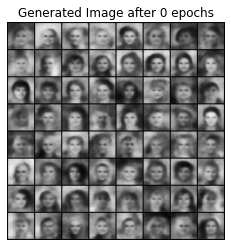

Epoch 2, Batch [500/3166], Training Loss 184.80878945390782
Epoch 2, Batch [1000/3166], Training Loss 89.63440002502503
Epoch 2, Batch [1500/3166], Training Loss 59.97488950967312
Epoch 2, Batch [2000/3166], Training Loss 45.105302651325665
Epoch 2, Batch [2500/3166], Training Loss 35.55382465486195
Epoch 2, Batch [3000/3166], Training Loss 30.28809603201067
Training Set Loss 2: 88464.0687
Epoch 3, Batch [500/3166], Training Loss 169.99906062124248
Epoch 3, Batch [1000/3166], Training Loss 88.52729291791792
Epoch 3, Batch [1500/3166], Training Loss 60.23654832388259
Epoch 3, Batch [2000/3166], Training Loss 44.86618309154577
Epoch 3, Batch [2500/3166], Training Loss 36.61260441676671
Epoch 3, Batch [3000/3166], Training Loss 30.806117664221407
Training Set Loss 3: 88129.0861
Epoch 4, Batch [500/3166], Training Loss 175.38104333667334
Epoch 4, Batch [1000/3166], Training Loss 88.67100694444444
Epoch 4, Batch [1500/3166], Training Loss 59.90056391761174
Epoch 4, Batch [2000/3166], Traini

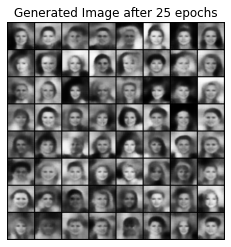

Epoch 27, Batch [500/3166], Training Loss 175.51446643286573
Epoch 27, Batch [1000/3166], Training Loss 84.84204517017017
Epoch 27, Batch [1500/3166], Training Loss 58.93455532855237
Epoch 27, Batch [2000/3166], Training Loss 45.15977520010005
Epoch 27, Batch [2500/3166], Training Loss 35.8750969137655
Epoch 27, Batch [3000/3166], Training Loss 30.16779291013671
Training Set Loss 27: 87511.5935
Epoch 28, Batch [500/3166], Training Loss 178.28137525050101
Epoch 28, Batch [1000/3166], Training Loss 87.21313501001
Epoch 28, Batch [1500/3166], Training Loss 59.68907917778519
Epoch 28, Batch [2000/3166], Training Loss 43.21717890195097
Epoch 28, Batch [2500/3166], Training Loss 35.651157337935174
Epoch 28, Batch [3000/3166], Training Loss 29.37093093531177
Training Set Loss 28: 87508.0854
Epoch 29, Batch [500/3166], Training Loss 173.81655498496994
Epoch 29, Batch [1000/3166], Training Loss 87.24813876376376
Epoch 29, Batch [1500/3166], Training Loss 59.55373373915944
Epoch 29, Batch [2000/

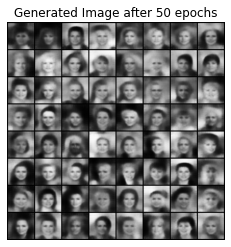

Epoch 52, Batch [500/3166], Training Loss 174.2937750501002
Epoch 52, Batch [1000/3166], Training Loss 89.09406281281281
Epoch 52, Batch [1500/3166], Training Loss 58.216331721147434
Epoch 52, Batch [2000/3166], Training Loss 44.80423024012006
Epoch 52, Batch [2500/3166], Training Loss 36.32845638255302
Epoch 52, Batch [3000/3166], Training Loss 29.566931164554852
Training Set Loss 52: 87450.8627
Epoch 53, Batch [500/3166], Training Loss 175.95857339679358
Epoch 53, Batch [1000/3166], Training Loss 86.83779873623624
Epoch 53, Batch [1500/3166], Training Loss 58.39484135256838
Epoch 53, Batch [2000/3166], Training Loss 43.895889350925465
Epoch 53, Batch [2500/3166], Training Loss 35.89392632052821
Epoch 53, Batch [3000/3166], Training Loss 30.526941272090696
Training Set Loss 53: 87449.0685
Epoch 54, Batch [500/3166], Training Loss 182.64646480460922
Epoch 54, Batch [1000/3166], Training Loss 89.35724005255256
Epoch 54, Batch [1500/3166], Training Loss 60.62037712641761
Epoch 54, Batch 

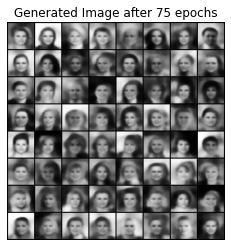

Epoch 77, Batch [500/3166], Training Loss 173.03002880761522
Epoch 77, Batch [1000/3166], Training Loss 88.06167104604604
Epoch 77, Batch [1500/3166], Training Loss 59.38482425783856
Epoch 77, Batch [2000/3166], Training Loss 45.63905781015508
Epoch 77, Batch [2500/3166], Training Loss 35.149178421368546
Epoch 77, Batch [3000/3166], Training Loss 31.081475075025008
Training Set Loss 77: 87417.5288
Epoch 78, Batch [500/3166], Training Loss 180.58335420841684
Epoch 78, Batch [1000/3166], Training Loss 89.50552114614615
Epoch 78, Batch [1500/3166], Training Loss 58.483197131420944
Epoch 78, Batch [2000/3166], Training Loss 44.9969516008004
Epoch 78, Batch [2500/3166], Training Loss 35.200730292116845
Epoch 78, Batch [3000/3166], Training Loss 29.67433936312104
Training Set Loss 78: 87417.1776
Epoch 79, Batch [500/3166], Training Loss 180.89922031563125
Epoch 79, Batch [1000/3166], Training Loss 87.90919826076076
Epoch 79, Batch [1500/3166], Training Loss 58.68589997498332
Epoch 79, Batch 

In [29]:
model, training_loss = train(model, train_loader, 100)

In [0]:
# saving the final model
torch.save(model.state_dict(), "./models/face_generatorE100v5.pt")

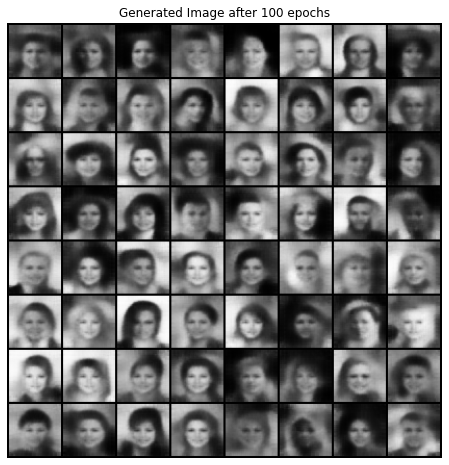

In [36]:
# let's test the model we've trained
z = torch.randn(64, 800)
if cuda:
    z = z.cuda()
model.eval()
with torch.no_grad():
    plt.figure(figsize=(8, 8))
    output = model.decode(z.float()).detach().cpu()
    grid = make_grid(output, nrow=8)
    plot_img(grid, epoch=100)

In [0]:
def sample(model, batch_size):
    z = torch.randn(batch_size, 800)
    if cuda:
        z = z.cuda()
    output = model.decode(z.float()).detach().cpu()
    grid = make_grid(output, nrow=8)
    plt.figure(figsize=(8, 8))
    plot_img(grid, epoch=100)

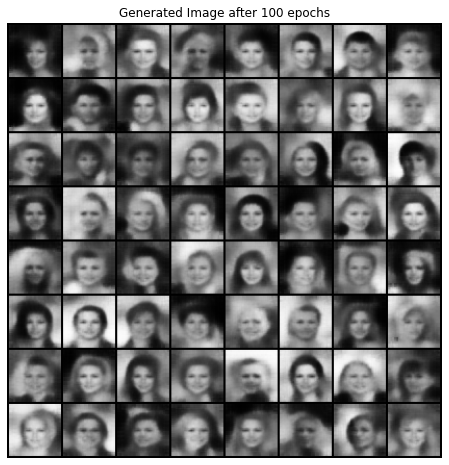

In [38]:
sample(model, 64)

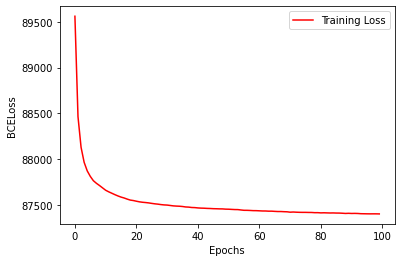

In [41]:
# I realised that the error values scale was wrong after a few epochs and didn't want to re-run the training so just left it
# the whole point is the loss should decrease over time :>
plt.plot(training_loss, 'r', label='Training Loss')
plt.ylabel('BCELoss')
plt.xlabel('Epochs')
plt.legend()
plt.show()